In [18]:
import random
import os
import numpy as np
import torch

def seed_everything(seed=1):
    """
    """
    # 1. Python & Numpy
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    # 2. PyTorch (CPU & GPU)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"🔒 Locked Random Seed: {seed}")



In [19]:
#import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [20]:
#load data
df_women =pd.read_csv(r"C:\Users\Lenovo\Documents\Neu 2025-2026\Lab\Hillstrom-Women.csv")
df_women = df_women.drop(columns="Unnamed: 0")
print ("---------------------------")
print ("null count:")
print (df_women.isnull().sum())
print ("---------------------------")
print(df_women.dtypes)
print ("---------------------------")
print ("labels:")
print(df_women.columns.tolist())
print ("---------------------------")
print("data shape:")
print(df_women.shape)


---------------------------
null count:
recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
visit              0
conversion         0
spend              0
treatment          0
dtype: int64
---------------------------
recency              int64
history_segment     object
history            float64
mens                 int64
womens               int64
zip_code            object
newbie               int64
channel             object
visit                int64
conversion           int64
spend              float64
treatment            int64
dtype: object
---------------------------
labels:
['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel', 'visit', 'conversion', 'spend', 'treatment']
---------------------------
data shape:
(42693, 12)


In [21]:
#Hillstrom-men
#split num and cate

cate_cols = ['zip_code', 'channel']
df_women["history_segment"] =df_women["history_segment"].map({
    "1) $0 - $100": '1', 
    "2) $100 - $200": '2', 
    "3) $200 - $350": "3",
    "4) $350 - $500": "4",
    "5) $500 - $750": "5",
    "6) $750 - $1,000": "6",
    "7) $1,000 +": "7"                         
})
num_cols = ['recency', "history", 'history_segment']
#split x y t
y_women = df_women["spend"]
t_women = df_women["treatment"]
x_women = df_women.drop(columns=["spend", "treatment", "visit", "conversion", 'history'])

x_women_encode = pd.get_dummies(x_women, columns=cate_cols, drop_first=True)
x_women_encode = x_women_encode.astype(float)
#train test split
x_women_train, x_women_test_val,t_women_train, t_women_test_val, y_women_train, y_women_test_val = train_test_split(x_women_encode,t_women.values, y_women.values, test_size=0.4, random_state=42, stratify=t_women)
x_women_val, x_women_test, t_women_val, t_women_test, y_women_val, y_women_test = train_test_split(x_women_test_val, t_women_test_val, y_women_test_val, test_size= 0.75, random_state=42, stratify=t_women_test_val)

#scale
# scaler = StandardScaler()
# x_women_train[num_cols]= scaler.fit_transform(x_women_train[num_cols])
# x_women_val[num_cols]= scaler.transform(x_women_val[num_cols])
# x_women_test[num_cols] = scaler.transform(x_women_test[num_cols])

x_women_train = x_women_train.values.astype(float)
x_women_val = x_women_val.values.astype(float)
x_women_test = x_women_test.values.astype(float)
print (x_women_train)

[[ 7.  2.  0. ...  1.  0.  1.]
 [10.  3.  0. ...  1.  0.  1.]
 [ 1.  4.  1. ...  0.  0.  0.]
 ...
 [12.  3.  0. ...  1.  1.  0.]
 [ 7.  6.  1. ...  0.  0.  0.]
 [ 1.  4.  0. ...  1.  1.  0.]]


In [ ]:
#Transform to tensor
def to_tensor(df):
    return torch.tensor(df, dtype=torch.float32)

x_women_train_t = to_tensor(x_women_train)
x_women_val_t = to_tensor(x_women_val)
x_women_test_t = to_tensor(x_women_test)

y_women_train_t = to_tensor(y_women_train).unsqueeze(1)
y_women_val_t = to_tensor(y_women_val).unsqueeze(1)
y_women_test_t = to_tensor(y_women_test).unsqueeze(1)

t_women_train_t = to_tensor(t_women_train.astype(float)).unsqueeze(1)
t_women_val_t = to_tensor(t_women_val.astype(float)).unsqueeze(1)
t_women_test_t = to_tensor(t_women_test.astype(float)).unsqueeze(1)

#Data loader
train_dataset = TensorDataset(x_women_train_t, t_women_train_t, y_women_train_t)
val_dataset = TensorDataset(x_women_val_t, t_women_val_t, y_women_val_t)
test_dataset = TensorDataset(x_women_test_t, t_women_test_t, y_women_test_t)

batch_size =6400
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print ("-------------------------------------------------------------")
print ("✅Completed tranform to tensor✅")
print (f"Shape of train: x={x_women_train_t.shape}; y ={y_women_train_t.shape}; t={t_women_train_t.shape}")
print (f"Shape of val: x={x_women_val_t.shape}; y={y_women_val_t.shape}; t={t_women_val_t.shape}")
print (f"Shape of test: x={x_women_test_t.shape}; y={y_women_test_t.shape}; t={t_women_test_t.shape}")



-------------------------------------------------------------
✅Completed tranform to tensor✅
Shape of train: x=torch.Size([25615, 9]); y =torch.Size([25615, 1]); t=torch.Size([25615, 1])
Shape of val: x=torch.Size([4269, 9]); y=torch.Size([4269, 1]); t=torch.Size([4269, 1])
Shape of test: x=torch.Size([12809, 9]); y=torch.Size([12809, 1]); t=torch.Size([12809, 1])


Evaluation metrics

In [23]:
from metrics import auuc, auqc, lift, krcc

Build Model

In [24]:
from dragonnet import DragonNet

In [25]:
# Thêm vào notebook trước khi train
print("📊 Data Distribution Check:")
print(f"Y train: mean={y_women_train.mean():.4f}, std={y_women_train.std():.4f}")
print(f"Y train zeros: {(y_women_train == 0).sum()} / {len(y_women_train)} ({(y_women_train == 0).sum()/len(y_women_train)*100:.1f}%)")
print(f"\nTreatment balance:")
print(f"  Train: {(t_women_train == 1).sum()} treated, {(t_women_train == 0).sum()} control")
print(f"  Test:  {(t_women_test == 1).sum()} treated, {(t_women_test == 0).sum()} control")

📊 Data Distribution Check:
Y train: mean=0.9650, std=14.8178
Y train zeros: 25422 / 25615 (99.2%)

Treatment balance:
  Train: 12832 treated, 12783 control
  Test:  6417 treated, 6392 control


In [26]:
# 1. Dataset info
print(f"\n1️⃣ Dataset:")
print(f"   Test size: {len(y_women_test)}")
print(f"   Treatment: {(t_women_test==1).sum()} ({(t_women_test==1).sum()/len(t_women_test)*100:.1f}%)")
print(f"   Control:   {(t_women_test==0).sum()} ({(t_women_test==0).sum()/len(t_women_test)*100:.1f}%)")


1️⃣ Dataset:
   Test size: 12809
   Treatment: 6417 (50.1%)
   Control:   6392 (49.9%)


In [27]:
# seed_everything(8)

In [ ]:
dragonnet = DragonNet(input_dim=x_women_train_t.shape[1], epochs=50, alpha = 0.0, beta =0.0, lr=0.001)
dragonnet.fit(train_loader, val_loader)

print ("Complete training")

Begin training Dragonnet Baseline🔃🔃🔃 
Epoch 1 | Train Loss: 11297869.0000 | VAL LOSS: 768135.5000
Epoch 2 | Train Loss: 11296194.0000 | VAL LOSS: 768071.9375
Epoch 3 | Train Loss: 11294704.0000 | VAL LOSS: 768038.1250
Epoch 4 | Train Loss: 11293293.0000 | VAL LOSS: 768053.7500
Epoch 5 | Train Loss: 11291835.0000 | VAL LOSS: 768190.2500
Epoch 6 | Train Loss: 11290498.0000 | VAL LOSS: 768550.1250
Epoch 7 | Train Loss: 11289832.0000 | VAL LOSS: 768890.8750
Epoch 8 | Train Loss: 11289544.0000 | VAL LOSS: 768952.4375
Epoch 9 | Train Loss: 11288884.0000 | VAL LOSS: 768804.6250
Epoch 10 | Train Loss: 11287996.0000 | VAL LOSS: 768591.0000
Epoch 11 | Train Loss: 11287201.0000 | VAL LOSS: 768394.0625
Epoch 12 | Train Loss: 11286584.0000 | VAL LOSS: 768253.6250
Epoch 13 | Train Loss: 11286103.0000 | VAL LOSS: 768176.1250
⏹️ Early stop at epoch 13 
Complete training


In [29]:
# Sau khi train xong
y0_pred, y1_pred, t_pred, _ = dragonnet.predict(x_women_test_t[:12000])  # Test 100 samples

print("\n📊 Model Output Check:")
print(f"y0_pred: min={y0_pred.min():.4f}, max={y0_pred.max():.4f}, mean={y0_pred.mean():.4f}")
print(f"y1_pred: min={y1_pred.min():.4f}, max={y1_pred.max():.4f}, mean={y1_pred.mean():.4f}")
print(f"t_pred:  min={t_pred.min():.4f}, max={t_pred.max():.4f}, mean={t_pred.mean():.4f}")

uplift = (y1_pred - y0_pred).numpy().flatten()
print(f"Uplift:  min={uplift.min():.4f}, max={uplift.max():.4f}, std={uplift.std():.4f}")

if uplift.std() < 0.01:
    print("⚠️ WARNING: Model is predicting almost constant uplift!")


📊 Model Output Check:
y0_pred: min=0.3245, max=1.1603, mean=0.5460
y1_pred: min=0.0000, max=0.0000, mean=0.0000
t_pred:  min=0.5902, max=0.9128, mean=0.6998
Uplift:  min=-1.1603, max=-0.3245, std=0.1539


Evaluating baseline🔃🔃🔃
         y    t      pred  bucket
0      0.0  0.0 -0.324546       0
5      0.0  0.0 -0.324546       0
9      0.0  0.0 -0.325609       0
10     0.0  0.0 -0.325609       0
11     0.0  0.0 -0.325609       0
...    ...  ...       ...     ...
12800  0.0  0.0 -1.152316      99
12801  0.0  0.0 -1.152316      99
12803  0.0  0.0 -1.152702      99
12804  0.0  0.0 -1.152702      99
12808  0.0  0.0 -1.160269      99

[6392 rows x 4 columns]
               y    t      pred  bucket
1       0.000000  1.0 -0.324546       0
2       0.000000  1.0 -0.324546       0
3       0.000000  1.0 -0.324546       0
4       0.000000  1.0 -0.324546       0
6       0.000000  1.0 -0.324546       0
...          ...  ...       ...     ...
12798  47.360001  1.0 -1.152089      99
12802   0.000000  1.0 -1.152702      99
12805   0.000000  1.0 -1.152702      99
12806   0.000000  1.0 -1.160269      99
12807   0.000000  1.0 -1.160269      99

[6417 rows x 4 columns]


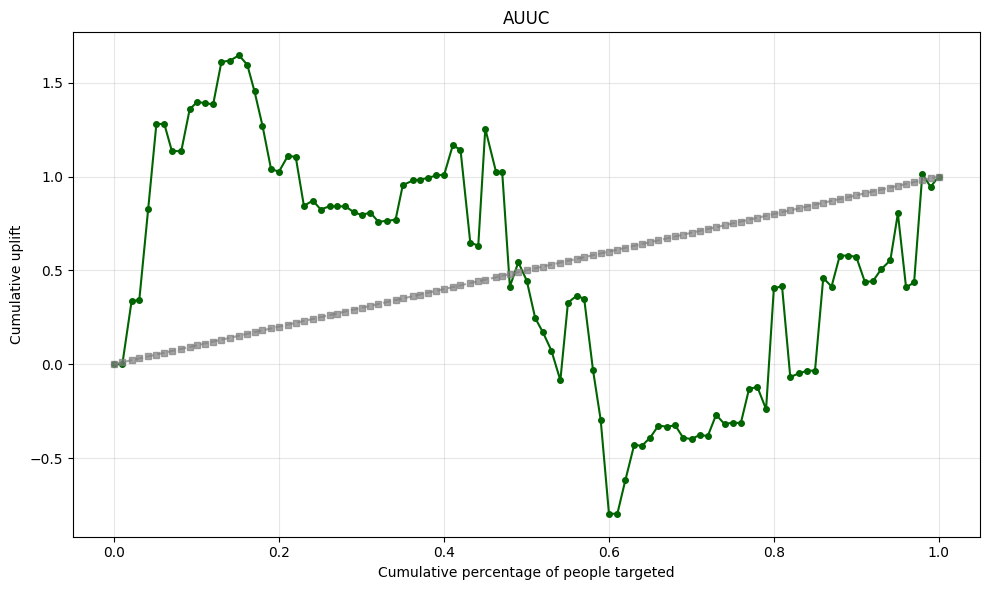

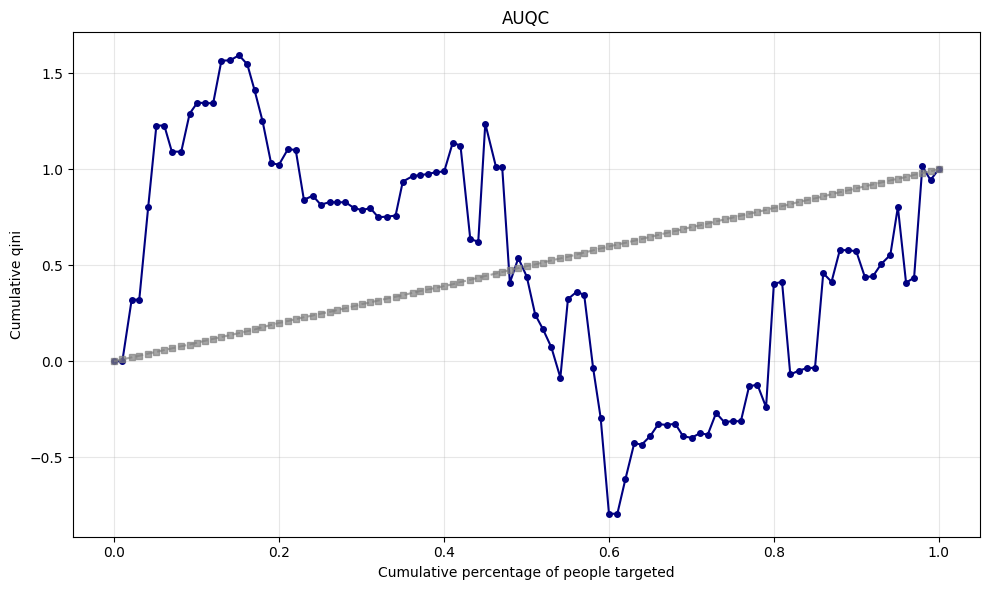

AUCC:  0.518964248266368
AUQC:  0.5080554739508343
Lift: 0.26578414
KRCC:  -0.03757575757575758


In [30]:
print ("Evaluating baseline🔃🔃🔃")
y0_pred, y1_pred, _ ,_= dragonnet.predict(x_women_test_t)

uplift_pred = (y1_pred - y0_pred).numpy().flatten()

y_true = y_women_test_t.numpy().flatten()
t_true = t_women_test_t.numpy().flatten()

auuc = auuc(y_true, t_true, uplift_pred, bins =100, plot = True)
auqc = auqc(y_true, t_true, uplift_pred, bins =100, plot = True)
lift = lift(y_true, t_true, uplift_pred, h=0.3, bins =100)
krcc = krcc(y_true, t_true, uplift_pred, bins=100 )
print ("AUCC: ",auuc)
print ("AUQC: ",auqc)
print ("Lift:", lift)
print ("KRCC: ",krcc)

In [31]:
# Check prediction distribution:
print(f"Uplift pred stats:")
print(f"  Min:    {uplift_pred.min():.4f}")
print(f"  Max:    {uplift_pred.max():.4f}")
print(f"  Std:    {uplift_pred.std():.4f}")
print(f"  Unique: {len(np.unique(uplift_pred))}")

# Nếu std < 0.1 hoặc unique values < 50:
# → Predictions quá giống nhau
# → pd.qcut() chia bins theo quantiles nhưng nhiều bins có cùng pred value
# → Randomness trong tie-breaking

Uplift pred stats:
  Min:    -1.1603
  Max:    -0.3245
  Std:    0.1547
  Unique: 2097


In [32]:
print(f"\n3️⃣ Outcome (y):")
print(f"   Zeros: {(y_women_test==0).sum()} ({(y_women_test==0).sum()/len(y_women_test)*100:.1f}%)")
print(f"   Mean:  {y_women_test.mean():.4f}")


3️⃣ Outcome (y):
   Zeros: 12713 (99.3%)
   Mean:  0.7891


In [33]:
y_treated = y_women_test[t_women_test==1]
y_control = y_women_test[t_women_test==0]
true_ate = y_treated.mean() - y_control.mean()
print(f"\n4️⃣ True ATE: {true_ate:.4f}")


4️⃣ True ATE: 0.1023


In [34]:
n_bins_recommended = max(10, min(100, len(y_women_test) // 20))
print(f"\n5️⃣ Binning:")
print(f"   Current:     100 bins")
print(f"   Recommended: {n_bins_recommended} bins")
print(f"   Samples/bin: {len(y_women_test) / n_bins_recommended:.1f}")


5️⃣ Binning:
   Current:     100 bins
   Recommended: 100 bins
   Samples/bin: 128.1
